In [75]:
#Data Wrangling
import numpy as np
import pandas as pd
import math as ma
from scipy.stats import randint as sp_randint
from scipy.special import comb

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC  

#Preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image 

import operator as op
from _functools import partial, reduce

#Bootstrap
from sklearn.utils import resample

from yellowbrick.regressor import ResidualsPlot

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Part 1: Load Data

In [3]:
StocksX = pd.read_csv("X.csv")
StocksY = pd.read_csv("Y.csv")

x_train, x_test, y_train, y_test = train_test_split(StocksX, StocksY, test_size=0.2, random_state=1)
y_train.head()

,comp4_xt+1
1699,-0.017681
639,0.012778
1002,-0.002755
1352,-0.005188
995,-0.007290


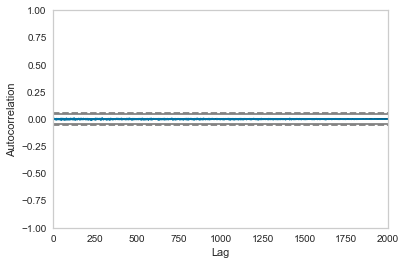

In [97]:
pd.plotting.autocorrelation_plot(x_train)

## Part 2: Explore Various Regression Models and Find the Best to Predict  $x_{t+1}$

In [4]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [93]:
#Linear Regression
LR = LinearRegression()
LR.fit(x_train, y_train)
score = LR.score(x_test, y_test)
mse = mean_squared_error(y_test, LR.predict(x_test))
print("test MSE: %.6f" % mse)
print("R squared for linear model: ",score)

test MSE: 0.000190
R squared for linear model:  -0.19017275422628166


optimal lambda:  2.9037695363635965e-05
number of non-zero coefficients:  0
[]
test MSE: 0.000160
R Squared: -0.004312


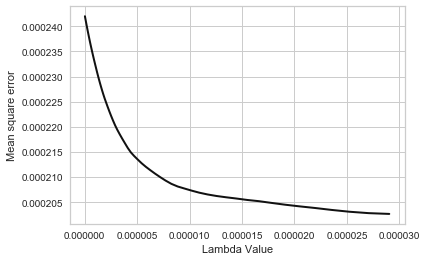

In [98]:
#Lasso
lasso_model = LassoCV(cv=5,max_iter=3000,
                      random_state=1).fit(x_train,y_train)
lambdas = lasso_model.alphas_
    
plt.figure()
plt.plot(lambdas, lasso_model.mse_path_.mean(axis=-1),'k',linewidth=2)

plt.xlabel('Lambda Value')
plt.ylabel('Mean square error')
plt.axis('tight')

print("optimal lambda: ",lasso_model.alpha_)
lasso = Lasso(alpha=lasso_model.alpha_, normalize=True)
lasso.fit(x_train,y_train)

print("number of non-zero coefficients: ",np.count_nonzero(lasso.coef_))
print(list(zip(lasso.coef_[lasso.coef_!=0], list(x_train))))

pred = lasso.predict(x_test)
rsq = lasso.score(x_test,y_test)
mse = mean_squared_error(y_test, pred)

print("test MSE: %.6f" % mse)
print("R Squared: %.6f" % rsq)

In [46]:
#Ridge
alphas = [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,100,1000,1e4]
x_scale = scale(x_train)
ridge_model = RidgeCV(alphas=alphas,cv=5).fit(x_scale,y_train)

print("optimal lambda: ",ridge_model.alpha_)
ridge = Ridge(alpha=ridge_model.alpha_,normalize=True)
ridge.fit(x_scale,y_train)

x_scale_test = scale(x_test)
pred = ridge.predict(x_scale_test)
rsq = ridge.score(x_scale_test,y_test)
mse = mean_squared_error(y_test, pred)

print("test MSE: %.6f" % mse)
print("R Squared: %.6f" % rsq)

optimal lambda:  10000.0
test MSE: 0.000160
R Squared: -0.004324


test MSE:  comp4_xt+1    0.000162
dtype: float64
R Squared: -0.015393
number of principal components selected: 3


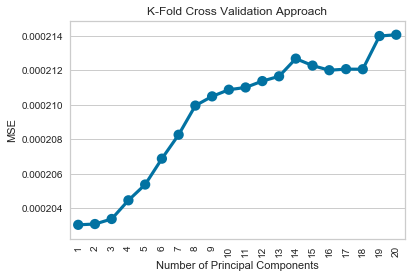

In [159]:
#PCA
score = np.array([])
pca = PCA(svd_solver='full')
X_reduced = pca.fit_transform(scale(x_train))
regr = LinearRegression()

cv_method = KFold(n_splits=5,shuffle=True,random_state = 1)
for i in np.arange(1,21):
    error = -1*np.mean(cross_val_score(regr,X_reduced[:,:i],y_train,cv = cv_method,
                                       scoring = 'neg_mean_squared_error'))
    score = np.append(score,error)
    
ax=sns.pointplot(x = np.arange(1,21),y = score)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('K-Fold Cross Validation Approach')
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')

n=3

regr.fit(X_reduced[:,:n],y_train)
X_test_reduced = pca.fit_transform(scale(x_test))

pred = regr.predict(X_test_reduced[:,:n])
rsq = regr.score(X_test_reduced[:,:n],y_test)
mse = np.mean((pred - y_test)**2)

print("test MSE: ",mse)
print("R Squared: %.6f" % rsq)
print("number of principal components selected: %d" % n)

Text(0,0.5,'Explained Variance')

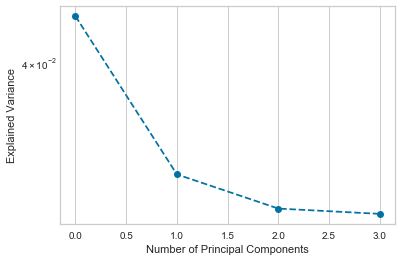

In [165]:
pca_trafo = PCA().fit(scale(x_train));

plt.semilogy(pca_trafo.explained_variance_ratio_[0:4], '--o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')

In [158]:
#PCA + Interaction
pca = PCA(svd_solver='full')

X_reduced = pca.fit_transform(scale(x_train))
poly_reduced = PolynomialFeatures(interaction_only=True,include_bias = False)

regr = LinearRegression()

n = 3
x_interact_reduced = poly_reduced.fit_transform(X_reduced[:,:n])
regr.fit(x_interact_reduced,y_train)
X_test_reduced = pca.fit_transform(scale(x_test))
x_interact_test_reduced = poly_reduced.fit_transform(X_test_reduced[:,:n])

pred = regr.predict(x_interact_test_reduced)
rsq = regr.score(x_interact_test_reduced,y_test)
mse = np.mean((pred - y_test)**2)

print("test MSE: ",mse)
print("R Squared: %.6f" % rsq)
print("number of principal components selected: %d" % n)

test MSE:  comp4_xt+1    0.000158
dtype: float64
R Squared: 0.007512
number of principal components selected: 3


In [89]:
#randomForest
clf = RandomForestRegressor()
param_dist = {"max_depth": sp_randint(1,10),
              "n_estimators": [100,150,200,250,300],
              "max_features": sp_randint(ma.floor(ma.log(x_train.shape[1],2)),
                                         ma.ceil(ma.sqrt(x_train.shape[1]))),
              "min_samples_leaf": [1, 2, 4],
              "min_samples_split": [2, 5, 10]}
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                                   cv=5, n_iter=50, random_state=1)
random_search.fit(x_train, y_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.009 (std: 0.005)
Parameters: {'max_depth': 1, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Model with rank: 2
Mean validation score: -0.009 (std: 0.006)
Parameters: {'max_depth': 1, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}

Model with rank: 3
Mean validation score: -0.010 (std: 0.007)
Parameters: {'max_depth': 1, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}



In [132]:
param_grid = {"max_depth": [1,2],
              "n_estimators": [150,200,300],
              "max_features": [7,8,9,10,11],
              "min_samples_leaf": [1,2,4],
              "min_samples_split": [2,5,10]}

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: -0.007 (std: 0.004)
Parameters: {'max_depth': 1, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}

Model with rank: 2
Mean validation score: -0.007 (std: 0.005)
Parameters: {'max_depth': 1, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 3
Mean validation score: -0.007 (std: 0.004)
Parameters: {'max_depth': 1, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}



In [91]:
clf.set_params(max_depth=1,max_features=7,min_samples_leaf=2,min_samples_split=10,n_estimators=150)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
rsq = clf.score(x_test,y_test)
mse = mean_squared_error(y_test, pred)
print("test MSE: %.6f" % mse)
print("R Squared: %.6f" % rsq)

test MSE: 0.000159
R Squared: 0.000426


## Part 3: Explore Various Classification Models and Find the Best to Predict  $x_{t+1} >= 0$

In [5]:
StocksY['comp4_xt+1_bi']=(StocksY['comp4_xt+1']>=0)
y_bi_train, y_bi_test = train_test_split(StocksY['comp4_xt+1_bi'], test_size=0.2, random_state=1)
y_bi_train.head()

1699    False
639      True
1002    False
1352    False
995     False
Name: comp4_xt+1_bi, dtype: bool

In [7]:
#L2 Logistics
train_logm = LogisticRegression(random_state=1, penalty='l2', solver='lbfgs',
                                multi_class='multinomial').fit(x_train,y_bi_train)
pred_y_log = train_logm.predict(x_test)
print(confusion_matrix(y_bi_test,pred_y_log))

[[ 84 133]
 [108 176]]


In [8]:
print("Accuracy:",accuracy_score(y_bi_test,pred_y_log))
print("Precision:",precision_score(y_bi_test,pred_y_log))
print("AUC: ",roc_auc_score(y_bi_test,pred_y_log))

Accuracy: 0.5189620758483033
Precision: 0.56957928802589
AUC:  0.5034075420263516


In [77]:
#Naive Bayes
y_gnb_train = pd.Series.to_frame(y_bi_train)
y_gnb_test = pd.Series.to_frame(y_bi_test)
gnb = GaussianNB()
gnb.fit(x_train,y_gnb_train)
y_pred_gnb = gnb.predict(x_test)

In [78]:
print(confusion_matrix(y_gnb_test,y_pred_gnb))

[[156  61]
 [191  93]]


In [79]:
print("Accuracy:",accuracy_score(y_gnb_test,y_pred_gnb))
print("Precision:",precision_score(y_gnb_test,y_pred_gnb))
print("AUC: ",roc_auc_score(y_gnb_test,y_pred_gnb))

Accuracy: 0.49700598802395207
Precision: 0.6038961038961039
AUC:  0.5231793989744922


In [135]:
#RandomForest
clc = RandomForestClassifier()
param_dist = {"max_depth": sp_randint(1,10),
              "n_estimators": [100,150,200,250,300],
              "max_features": sp_randint(ma.floor(ma.log(x_train.shape[1],2)),
                                         ma.ceil(ma.sqrt(x_train.shape[1]))),
              "min_samples_leaf": [1, 2, 4],
              "min_samples_split": [2, 5, 10]}
random_search = RandomizedSearchCV(clc, param_distributions=param_dist, 
                                   cv=5, n_iter=50, random_state=1)
random_search.fit(x_train, y_bi_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.518 (std: 0.011)
Parameters: {'max_depth': 9, 'max_features': 13, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.517 (std: 0.018)
Parameters: {'max_depth': 8, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.516 (std: 0.010)
Parameters: {'max_depth': 3, 'max_features': 13, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}



In [139]:
param_grid = {"max_depth": [3,8,9,None],
              "n_estimators": [100,300],
              "max_features": [11,12,13],
              "min_samples_leaf": [2,4],
              "min_samples_split": [5,10]}

grid_search = GridSearchCV(clc, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_bi_train)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.526 (std: 0.019)
Parameters: {'max_depth': 3, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.522 (std: 0.014)
Parameters: {'max_depth': 3, 'max_features': 13, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.519 (std: 0.026)
Parameters: {'max_depth': 8, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}



In [5]:
clc.set_params(max_depth=3,max_features=11,min_samples_leaf=2,min_samples_split=10,n_estimators=100)
clc.fit(x_train, y_bi_train)
pred = clc.predict(x_test)
print(confusion_matrix(y_bi_test,pred))

[[ 57 160]
 [ 89 195]]


In [6]:
print("Accuracy:",accuracy_score(y_bi_test,pred))
print("Precision:",precision_score(y_bi_test,pred))
print("AUC: ",roc_auc_score(y_bi_test,pred))

Accuracy: 0.5029940119760479
Precision: 0.5492957746478874
AUC:  0.47464626468488347


In [47]:
#SVC
svc_ker = SVC()
param_dist = {"kernel":['linear'],
            "C":np.linspace(100,1000,10)}
random_search = RandomizedSearchCV(svc_ker, param_distributions=param_dist, 
                                   cv=5, n_iter=20, random_state=1)
random_search.fit(x_train, y_bi_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.509 (std: 0.028)
Parameters: {'kernel': 'linear', 'C': 400.0}

Model with rank: 2
Mean validation score: 0.508 (std: 0.021)
Parameters: {'kernel': 'linear', 'C': 900.0}

Model with rank: 3
Mean validation score: 0.507 (std: 0.025)
Parameters: {'kernel': 'linear', 'C': 600.0}

Model with rank: 3
Mean validation score: 0.507 (std: 0.022)
Parameters: {'kernel': 'linear', 'C': 1000.0}



In [195]:
#SVC with kernel
svc_ker = SVC()
param_dist = {"kernel":['rbf','sigmoid','poly'],
            "C":np.linspace(100,1000,10),
             "degree":[1,2,3,4,5]}
random_search = RandomizedSearchCV(svc_ker, param_distributions=param_dist, 
                                   cv=5, n_iter=20, random_state=1)
random_search.fit(x_train, y_bi_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.515 (std: 0.011)
Parameters: {'kernel': 'sigmoid', 'degree': 5, 'C': 300.0}

Model with rank: 2
Mean validation score: 0.509 (std: 0.001)
Parameters: {'kernel': 'poly', 'degree': 4, 'C': 500.0}

Model with rank: 2
Mean validation score: 0.509 (std: 0.001)
Parameters: {'kernel': 'poly', 'degree': 3, 'C': 900.0}

Model with rank: 2
Mean validation score: 0.509 (std: 0.001)
Parameters: {'kernel': 'poly', 'degree': 3, 'C': 100.0}

Model with rank: 2
Mean validation score: 0.509 (std: 0.001)
Parameters: {'kernel': 'poly', 'degree': 5, 'C': 800.0}

Model with rank: 2
Mean validation score: 0.509 (std: 0.001)
Parameters: {'kernel': 'poly', 'degree': 4, 'C': 200.0}

Model with rank: 2
Mean validation score: 0.509 (std: 0.001)
Parameters: {'kernel': 'poly', 'degree': 5, 'C': 300.0}



In [55]:
param_grid = {"kernel":['sigmoid'],
            "C":np.linspace(200,400,21)}
grid_search = GridSearchCV(svc_ker, param_grid=param_grid,cv=5)
grid_search.fit(x_train, y_bi_train)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.515 (std: 0.021)
Parameters: {'C': 340.0, 'kernel': 'sigmoid'}

Model with rank: 1
Mean validation score: 0.515 (std: 0.021)
Parameters: {'C': 350.0, 'kernel': 'sigmoid'}

Model with rank: 3
Mean validation score: 0.515 (std: 0.011)
Parameters: {'C': 300.0, 'kernel': 'sigmoid'}



In [56]:
svc_ker = SVC()
param_grid = {"kernel":['sigmoid'],
            "C":np.linspace(1000,2000,11)}
grid_search = GridSearchCV(svc_ker, param_grid=param_grid,cv=5)
grid_search.fit(x_train, y_bi_train)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.502 (std: 0.016)
Parameters: {'C': 1000.0, 'kernel': 'sigmoid'}

Model with rank: 2
Mean validation score: 0.500 (std: 0.020)
Parameters: {'C': 1300.0, 'kernel': 'sigmoid'}

Model with rank: 2
Mean validation score: 0.500 (std: 0.024)
Parameters: {'C': 1400.0, 'kernel': 'sigmoid'}



In [73]:
#sigmoid svm
svclassifier_sig = SVC(kernel='sigmoid',C=340)  
svclassifier_sig.fit(x_train, y_bi_train)  
y_pred_svm = svclassifier_sig.predict(x_test)  
print(confusion_matrix(y_bi_test,y_pred_svm))

[[ 24 193]
 [ 49 235]]


In [74]:
print("Accuracy:",accuracy_score(y_bi_test,y_pred_svm))
print("Precision:",precision_score(y_bi_test,y_pred_svm))
print("AUC: ",roc_auc_score(y_bi_test,y_pred_svm))

Accuracy: 0.5169660678642715
Precision: 0.5490654205607477
AUC:  0.4690319335367041


## Part 4: Encapsulate the model and prediction steps into a function for the two best models found (use the exact 2 cells provided below to do this)

In [48]:
def predict_price(X_train, y_train, X_test):
    n=3
    pca = PCA(svd_solver='full')
    regr = LinearRegression()
    
    X_reduced = pca.fit_transform(scale(x_train))
    poly_reduced = PolynomialFeatures(interaction_only=True,include_bias = False)
    x_interact_reduced = poly_reduced.fit_transform(X_reduced[:,:n])

    regr.fit(x_interact_reduced,y_train)
    X_test_reduced = pca.fit_transform(scale(X_test))
    x_interact_test_reduced = poly_reduced.fit_transform(X_test_reduced[:,:n])

    y_hat_test = regr.predict(x_interact_test_reduced)
    
    return y_hat_test

In [218]:
def predict_dir(X_train,y_train,X_test):
    
    gnb = GaussianNB()
    gnb.fit(x_train,y_train)
    y_hat_test = gnb.predict(x_test)
    
    return y_hat_test